<a id="top" style="float:right;" href="http://dynfluid.ensam.eu/"><img style="height:120px;" src="http://dynfluid.ensam.eu/uas/DYNFLUID/logoPrincipal/Logo-DynFluid-Web.png"/></a>
<a style="float:left;" href="http://www.cnam.fr//"><img style="height:120px;" src="https://upload.wikimedia.org/wikipedia/commons/4/45/Logo_ENSTA_Paris.jpg"></a>

<center>
<h3 style="color:#888888;"> <i>--  Introduction à  la méthode de Boltzmann sur Réseau  --</i> </h3>
<h1> TP n°3 </h1>
<h3> Ecoulement autour d'un cylindre Carré </h3>

<h6><a href="mailto:simon.marie@lecnam.net">simon.marie@lecnam.net</a></h6>
</center>

<h1> Préambule </h1>

Le TP doit être rendu sous la forme d'un Notebook jupyter en respectant la nomenclature suivante:
<center>
<b>TP3_NOM1_NOM2.ipynb</b>
</center>

Tous les résultats, discussions, analyses, doivent donc être inclus dans le fichier.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import Image
import matplotlib.patches as patches

fs=20
# plt.style.use('seaborn-dark')
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)
%matplotlib inline
#%matplotlib notebook

<h1>Présentation du TP</h1>

On se propose dans se TP de simuler numériquement l'écoulement d'un fluide autour d'un cylindre carré à  l'aide d'un code Lattice Boltzmann utilisant le modèle $D2Q9$.

<h2>Le modèle D2Q9</h2>

Le modèle à 9 vitesses de la méthode de Boltzmann sur réseau assure l'égalité des moments jusqu'à  l'ordre 2 et permet donc la simulation des écoulements visqueux régit par les équations de Navier-Stokes avec une limitation en nombre de Mach.
Les paramètres du modéle sont résumés dans le tableau suivant:

<table style="width:800px;text-align:center;">
<tr><td>$c_\alpha$</td><td>$\omega_\alpha$</td><td>$c_0$</td><td>$\tau_g$</td></tr>
<tr><td>$(0,0)\\ (1,0) (0,1) (-1,0) (0,-1)\\ (1,1) (-1,1) (-1,-1) (1,-1)$</td><td>$\dfrac{4}{9},\\ \dfrac{1}{9},\dfrac{1}{9},\dfrac{1}{9},\dfrac{1}{9},\\ \dfrac{1}{36},\dfrac{1}{36},\dfrac{1}{36},\dfrac{1}{36}$</td><td>$\dfrac{1}{\sqrt{3}}$</td><td width=30%>$\dfrac{1}{2}+\dfrac{\tilde{\nu}}{c_0^2}$</td></tr>
</table>

La fonction d'équilibre du modèle s'écrit:
$$
\displaystyle{g_{\alpha}^{eq}=\rho\omega_\alpha\left(1+\dfrac{c_{\alpha,i}u_i}{c_0^2}+\dfrac{(c_{\alpha,i}u_i)^2}{2c_0^4}-\dfrac{u_i^2}{2c_0^2}\right)}
$$

et son algorithme général:
$$
\displaystyle{g_{\alpha}^{coll} = g_{\alpha}-\dfrac{1}{\tau_g}[g_{\alpha}-g_{\alpha}^{eq}]\\
g_{\alpha}(x,y) = g_{\alpha}^{coll}(x-c_{\alpha,x},y-c_{\alpha,y})}
$$

Les variables macroscopiques sont calculées à  partir des moments des fonctions de distribution:
$$
\rho=\sum_{\alpha=1}^9 g_{\alpha}
$$

$$
\rho u_x=\sum_{\alpha=1}^9 c_{\alpha,x}g_{\alpha}
$$

$$
\rho u_y=\sum_{\alpha=1}^9 c_{\alpha,y}g_{\alpha}
$$


<h2>Le cylindre carré</h2>

L'écoulement autour d'un cylindre carré est un cas test très utilisé en CFD et en particulier en Lattice Boltzmann car il présente l'avantage d'avoir une géométrie cartésienne simple. Le nombre de Reynolds de cet écoulement est basé sur le coté $D$ du carré:
$$
Re=\dfrac{U_0 D}{\nu}
$$

<center>
<img src="https://hpp.education/Lessons/LBM/ENSTA/SquareCylinder.png" style="width:650px;"/>
    <b><i>Figure 1: Géométrie du domaine de calcul</i></b>
</center>


Au delà  d'une valeur critique $R_e=48$, l'écoulement devient instable et on observe une allée de von Karmann se former, caractérisée par des tourbillons en opposition de phase en aval du cylindre. Pour les faibles nombres de Reynolds ($Re<500$), on peut estimer la distance $\delta$ moyenne entre les tourbillons: $\delta\sim 2.5 D$

In [4]:
Image("/content/CL.PNG", width = 300, height = 300)

FileNotFoundError: No such file or directory: '/content/CL.PNG'

FileNotFoundError: No such file or directory: '/content/CL.PNG'

<IPython.core.display.Image object>

<h1>Travail demandé</h1>
<h2>Définition des paramètres et des fonctions</h2>

Pour les paramètres du calcul, on définira tous le domaine à  partir du Rayon du cylindre carré $R$. On prendra un domaine $(L_x, L_y)=(40R,20R)$ de résolution $(n_x,n_y)$ mailles. On placera le cylindre à  8 rayons du bord gauche du domaine (input) et à égale distance des bors hauts et bas.

On souhaite réaliser plusieurs simulations en faisant varier le nombre de Reynolds et le type de conditions aux limites. Le nombre de Mach sera fixé à  $M_0=0.3$.

<b style="color:#0055FA">1. Completer la cellule suivante à  partir des données fournies et des définition du cours. On commencera par représenter le rayon du cylindre avec 5 mailles.</b>

In [5]:
ca= [(0,0),(0,1),(1,0),(0,-1),(-1,0),(1,1),(1,-1),(-1,-1),(-1,1)] #nodes

w=[4/9,1/9,1/9,1/9,1/9,1/36,1/36,1/36,1/36,1/36] #Weights of the quadrature

c0=1/np.sqrt(3) #Normalized celerity sound of the lattice

# Maillage/Domaine
R = 5  # rayon du cylindre
x0, y0= 8*R, 10*R # centre du cylindre
nx = 50*R
ny = 25*R

# Taille de maille:
dx = 1/nx
dy = 1/ny

x = np.linspace(0,2,nx)
y = np.linspace(0,1,ny)

# Vitesse du son réelle à  293K:
c0_real = 330

# Pas de temps:
dt=dx/c0_real*c0

# Mach:
M0=0.3

<b style="color:#0055FA">2. Compléter chacune des fonctions suivantes correspondant aux étapes de l'algorithme</b>
    
<b>Initialisation:</b> Définir la fonction permettant d'initialiser le domaine avec une densité uniforme $\rho=1$, et une vitesse uniforme $U_0$. Calculer également le paramètre de relaxation $\tau_g$ en fonction du nombre de Reynolds souhaité:

In [6]:
def init(M0, Re):
    """
    M0 is the Mach number and Re the Reynolds number.
    Initializes the distribution function, volume density and velocity.
    """
    # Initialisation du domaine
    rho = np.ones((ny,nx))
    geq = np.zeros((9,ny,nx))
    ux = np.zeros((ny,nx))
    uy = np.zeros((ny,nx))

    U0 = M0*c0 #U0 adimensionné -------------------------------
    nu = U0*ny/Re #Viscosity
    ux[:,0] = U0
    taug=1/2 + nu/c0**2

    eq(rho,ux,uy,geq)
    return geq, rho, ux, uy, taug, U0

<b>Equilibre:</b>  Dans ce TP nous avons besoin de calculer explicitement les fonctions de distribution à  l'équilibre. Définir la fonction permettant la mise à  jour de ces distributions en fonction des moments $\rho$, $u_x$ et $u_y$.

In [7]:
def eq(rho, ux, uy, geq):
    # Mise à  jour de geq
    for i in range(9):
        geq[i] = w[i]*rho*(1 + 3*(ca[i][1]*ux + ca[i][0]*uy) + 9/2*(ca[i][1]*ux + ca[i][0]*uy)**2 - 3/2*(ux**2 + uy**2))

<b>Collision:</b>  Ecrire simplement l'étape de collision:

In [8]:
def collide(geq: np.array, g: np.array, taug: int):
    # Etape de collision
    gcoll = g - 1/taug*(g - geq)
    return gcoll

<b>Propagation:</b> Pour cette étape on pourra utiliser du slicing plutôt qu'une boucle sur l'espace.

In [9]:
def propagate(g, gcoll):
  """
  Propagate the distribution function. DO NOT pay attention to boundary conditions for now.
  """
  g[0] = gcoll[0]

  gcoll_shift_r = np.roll(gcoll[1], 1, axis = 1)
  gcoll_shift_r[:,0] = g[1,:,0]
  gcoll_shift_l = np.roll(gcoll[3], -1, axis = 1)
  gcoll_shift_l[:,-1] = g[3,:,-1]
  # Etape de propagation
  g[1] = gcoll_shift_r
  g[3] = gcoll_shift_l

  gcoll_shift_r = np.roll(gcoll[2], -1, axis = 0)
  gcoll_shift_r[-1] = g[2,-1]
  gcoll_shift_l = np.roll(gcoll[4], 1, axis = 0)
  gcoll_shift_l[0] = g[4,0]
  # Etape de propagation
  g[2] = gcoll_shift_r
  g[4] = gcoll_shift_l

  tmp = np.array(g[5,-1], copy = True)
  tmp2 = np.array(g[5,:,0], copy = True)
  g[5] = np.roll(gcoll[5], (-1,1), axis = (0,1))
  g[5,-1] = tmp
  g[5,:,0] = tmp2

  tmp = np.array(g[6,-1], copy = True)
  tmp2 = np.array(g[6,:,-1], copy = True)
  g[6] = np.roll(gcoll[6], (-1,-1), axis = (0,1))
  g[6,-1] = tmp
  g[6,:,-1] = tmp2

  tmp = np.array(g[7,0], copy = True)
  tmp2 = np.array(g[7,:,-1], copy = True)
  g[7] = np.roll(gcoll[7], (1,-1), axis = (0,1))
  g[7,0] = tmp
  g[7,:,-1] = tmp2

  tmp = np.array(g[8,0], copy = True)
  tmp2 = np.array(g[8,:,0], copy = True)
  g[8] = np.roll(gcoll[8], (1,1), axis = (0,1))
  g[8,0] = tmp
  g[8,:,0] = tmp2

<b>Calcul des moments:</b> Calcul les variables macroscopiques $\rho$,$u_x$,$u_y$

In [10]:
def macro(g,rho,ux,uy):
    # calcul des variables macro
    rho[:,:] = g[0] + g[1] + g[2] + g[3] + g[4] + g[5] + g[6] + g[7] + g[8]
    ux[:,:] = (g[1] - g[3] + g[5] - g[6] - g[7] + g[8])/rho
    uy[:,:] = (g[2] - g[4] + g[5] + g[6] - g[7] - g[8])/rho

<b>Condition aux limites solide:</b> Définir la fonction permettant de mettre à jour les distributions inconnues sur les parois solides. On distinguera dans ce TP la version avec frotement et la version sans frottement.

In [11]:
def wall_slip(gcoll,g,mask):
    # Paroi solide sur le cylindre: Bounce back avec frottement
    g[1,mask==1], g[3,mask==1] = gcoll[3,mask==1], gcoll[1,mask==1]
    g[2,mask==1], g[4,mask==1] = gcoll[4,mask==1], gcoll[2,mask==1]
    g[5,mask==1], g[7,mask==1] = gcoll[7,mask==1], gcoll[5,mask==1]
    g[6,mask==1], g[8,mask==1] = gcoll[8,mask==1], gcoll[6,mask==1]

In [12]:
def wall_no_slip(gcoll,g,mask):
    # Paroi solide sur le cylindre: Bounce back sans frottement
    #Face supérieur
    g[4,y0 - R,x0 - R : x0 + R + 1] = gcoll[2,y0 - R,x0 - R : x0 + R + 1]
    g[8,y0 - R,x0 - R : x0 + R + 1] = gcoll[5,y0 - R,x0 - R : x0 + R + 1]
    g[7,y0 - R,x0 - R : x0 + R + 1] = gcoll[6,y0 - R,x0 - R : x0 + R + 1]

    #Face inférieur
    g[2,y0 + R,x0 - R : x0 + R + 1] = gcoll[4,y0 + R,x0 - R : x0 + R + 1]
    g[5,y0 + R,x0 - R : x0 + R + 1] = gcoll[8,y0 + R,x0 - R : x0 + R + 1]
    g[6,y0 + R,x0 - R : x0 + R + 1] = gcoll[7,y0 + R,x0 - R : x0 + R + 1]

    #Face droite
    g[1,y0 - R : y0 + R + 1,x0 + R] = gcoll[3,y0 - R : y0 + R + 1,x0 + R]
    g[5,y0 - R : y0 + R + 1,x0 + R] = gcoll[6,y0 - R : y0 + R + 1,x0 + R]
    g[8,y0 - R : y0 + R + 1,x0 + R] = gcoll[7,y0 - R : y0 + R + 1,x0 + R]

    #Face gauche
    g[3,y0 - R : y0 + R + 1,x0 - R] = gcoll[1,y0 - R : y0 + R + 1,x0 - R]
    g[7,y0 - R : y0 + R + 1,x0 - R] = gcoll[8,y0 - R : y0 + R + 1,x0 - R]
    g[6,y0 - R : y0 + R + 1,x0 - R] = gcoll[5,y0 - R : y0 + R + 1,x0 - R]

#    ----------------------------------------------------------------------

<b>Condition aux limites fluide:</b> Définir la fonction permettant de mettre à jour les moments $u_x, \rho_{in}$ et les distributions inconnues à  l'entrée du domaine. On utilisera les approches vues dans le cours pour le bounce-back hors équilibre (NEBB):

$$
g_\alpha-g_{\alpha}^{eq}=g_\overline{\alpha}-g_\overline{\alpha}^{eq}
$$

Ici $\overline{\alpha}$ désigne la vitesse opposée à  la vitesse $\alpha$.

Exprimer la densité en entrée $\rho_{in}$ en fonction des distributions connues et de la vitesse $U_0$

___
$\rho_{in}=\dfrac{1}{1 - U_{0}}(\displaystyle{2\sum g_{\alpha_{k}}  + \sum g_{\alpha_{t}}})$, où les $\alpha_{k}$ désignent les coefficients dont les vitesses $c_{\alpha_{k}}$ sont dans le sens opposé à $\vec{U_{0}}$ et $c_{\alpha_{t}}$ les coefficients perpendiculaires à ce vecteur.

$\rho_{in}=\dfrac{1}{1 - U_{0}}(g_{0} + g_{2} + g_{4} + 2(g_{3} + g_{6} + g_{7}))$
___

En identifiant les distributions inconnues en entrée, simplifier l'expression ci-dessus en fonction des moments connu sur le bord supérieur:

___
$g_\alpha = g_{\alpha}^{eq} + g_\overline{\alpha}-g_\overline{\alpha}^{eq}$

$g_\alpha = \rho\omega_\alpha\left(1+\dfrac{c_{\alpha,i}u_i}{c_0^2}+\dfrac{(c_{\alpha,i}u_i)^2}{2c_0^4}-\dfrac{u_i^2}{2c_0^2}\right) +  g_\overline{\alpha} - \rho\omega_\overline{\alpha}\left(1+\dfrac{c_{\overline{\alpha},i}u_i}{c_0^2}+\dfrac{(c_{\overline{\alpha},i}u_i)^2}{2c_0^4}-\dfrac{u_i^2}{2c_0^2}\right)$
\
Or, $\omega_{\alpha} = \omega_{\overline{\alpha}}$ et $c_{\overline{\alpha}} = - c_{\alpha}$
\
$g_\alpha = g_\overline{\alpha} + 2\rho\omega_{\alpha}\dfrac{c_{\alpha,i}u_{i}}{c_{0}^{2}}$

Donc
$g_1 = g_3 + 2/3U_0\rho$

$g_5 = g_7 + 1/6(U_0 + u_y)\rho$

$g_8 = g_6 + 1/6(U_0 - u_y)\rho$
___




In [13]:
def inflow(g,rho,ux,uy,M0):
    # Conditions de vitesse au bord gauche
    U0 = M0*c0
    ux[:,0]= U0
    # Macro: On impose ux et on en déduit rho_in
    rho[:,0] = 1/(1-U0)*(2*(g[3,:,0] + g[7,:,0] + g[6,:,0]) + g[2,:,0] + g[4,:,0] + g[0,:,0])

    # Distributions: On impose les distributions inconnues avec le Bounce-Back hors equilibre
    g[1,:,0] = g[3,:,0] + 2/3*U0*rho[:,0]
    g[5,:,0] = g[7,:,0] + 1/6*(U0 + uy[:,0])*rho[:,0]
    g[8,:,0] = g[6,:,0] + 1/6*(U0 - uy[:,0])*rho[:,0]

<b>Condition aux limites en sortie:</b> Pour les fonctions de distributions inconnues en sortie, on imposera une condition de gradient nul:

$$
\dfrac{\partial g_\alpha}{\partial x_n}=0
$$

Ou $x_n$ désigne ici la normale à la paroi concernée.

In [14]:
def outflow(g,gcoll):
    # Conditions de gradient nul
    # Right
    g[3,:,-1] = g[3,:,-2]
    g[6,:,-1] = g[6,:,-2]
    g[7,:,-1] = g[7,:,-2]
    # Top
    g[7,0,:] = g[7,1,:]
    g[4,0,:] = g[4,1,:]
    g[8,0,:] = g[8,1,:]
    # Bottom
    g[2,-1,:] = g[2,-2,:]
    g[6,-1,:] = g[6,-2,:]
    g[5,-1,:] = g[5,-2,:]

<h2>Calcul</h2>

<b style="color:#0055FA">3. Une fois les paramètres et les fonctions définis, fixer le nombre de Reynolds (on commencera par $Re=20$), initialiser les distributions à leur valeur d'équilibre puis définir les mailles concernées par une condition aux limites solide.</b> Pour cela on pourra utiliser une variable de type *mask* de la même taille que le domaine et valant 0 pour une maille fluide et 1 pour une maille solide.

In [15]:
# Marquage des conditions aux limites:
# Fluide: mask=0
# Solide: mask=1
mask=np.zeros((ny,nx));
mask[y0 - R:y0 + R + 1,x0 - R] = 1
mask[y0 - R : y0 + R + 1,x0 + R] = 1
mask[y0 - R, x0 - R: x0 + R + 1] = 1
mask[y0 + R + 1, x0 - R: x0 + R + 1] = 1

<b style="color:#0055FA">4. Definir une fonction permettant le calcul du coefficient de trainée du cylindre  $C_d$: </b>

La force de trainée s'exprime:

$$
F_d=\dfrac{1}{2}\rho U_0^2 S_{ref} C_d = \int_{wall}p dS_x
$$

Ou $dS_x$ est un élément de surface projeté sur l'axe x.

Montrer que l'on peut donc approximer dans le cas du carré:
$$
C_d \sim \dfrac{c_0^2}{p_{dyn} S_{ref}} \left(\sum_{w+}\rho - \sum_{w-}\rho  \right )
$$

Ou $w_+$ et $w_-$ représentent les 2 faces avant et arrière du cylindre.

In [16]:
def dragcoeff(rho,mask,M0):
    Sref = 2*R
    pdyn = 1/2*(M0*c0)**2
    rho_top = np.sum(rho[y0 - R - 1, x0 - R : x0 + R + 1])
    rho_bottom = np.sum(rho[y0 + R + 1, x0 - R: x0 + R + 1])
    return c0**2/(pdyn*Sref)*(rho_top - rho_bottom)

<b style="color:#0055FA">5. Réaliser une boucle temporelle de 5000 itérations permettant l'enregistrement du coefficient de trainée en fonction du temps.

In [17]:
nt=5000
# Nombre de Reynolds:
Re = [500, 1000, 1500, 2000, 2500, 3000]
Ux = []
Uy = []
Rho = []
Cd_list = []
for re in Re:
  start=time.time()
  # initialisation:
  geq, rho, ux, uy, taug, U0=init(M0,re)
  g, gcoll= geq.copy(), geq.copy()
  Cd=np.zeros(nt)
  for it in np.arange(nt):
      gcoll = collide(geq,g,taug)
      propagate(g, gcoll)

      wall_slip(gcoll,g,mask)
      inflow(g,rho,ux,uy,M0)
      outflow(g,gcoll)

      macro(g,rho,ux,uy) #
      eq(rho,ux,uy,geq) #Update geq

      Cd[it] = dragcoeff(rho,mask,M0)
  tcal=time.time()-start
  Ux += [ux]
  Uy += [uy]
  Rho += [rho]
  Cd_list += [Cd]
  mlups=nx*ny*1e-6*nt/tcal
  print(str(nt)+" itérations en "+str(tcal)+"s: Performances: "+str(mlups)+"  MLUPS")

5000 itérations en 47.01550912857056s: Performances: 3.323371434151915  MLUPS
5000 itérations en 42.23278570175171s: Performances: 3.699732267329909  MLUPS
5000 itérations en 42.762227058410645s: Performances: 3.6539256897582026  MLUPS
5000 itérations en 42.163790702819824s: Performances: 3.7057863487959666  MLUPS
5000 itérations en 42.50812911987305s: Performances: 3.6757675116534663  MLUPS
5000 itérations en 43.63048315048218s: Performances: 3.5812117748293426  MLUPS


On observe un régime transitoire jusqu'à $t\approx 1000 \Delta t$, puis un régime périodique.

Text(0.5, 0, 'Time')

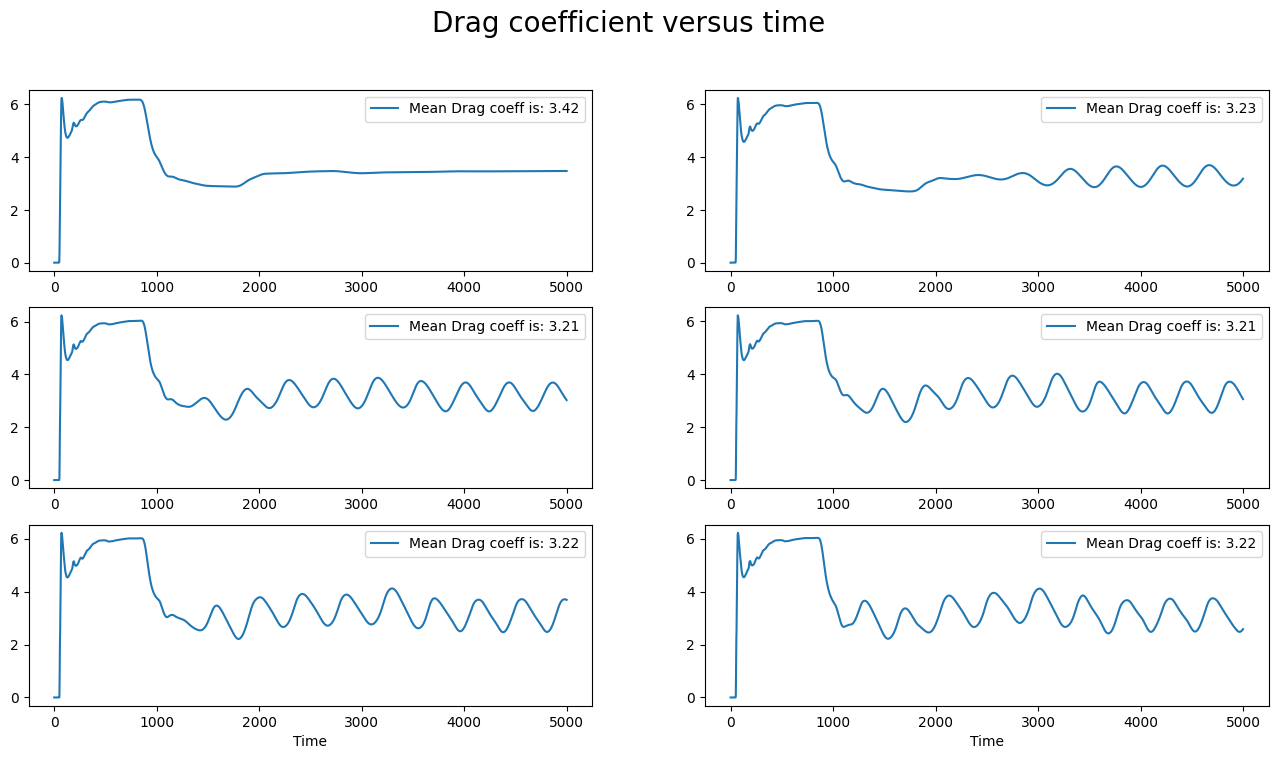

In [25]:
import statistics
fig, ax = plt.subplots(3,2, figsize = (16,8))
plt.subplots_adjust(hspace = .2)
fig.suptitle("Drag coefficient versus time", fontsize = 20)

for i in range(6):
  ax_ = ax[i//2][i%2]
  mean = statistics.mean(Cd_list[i][2000:])
  ax_.plot(Cd_list[i], label = f"Mean Drag coeff is: " + str(mean)[:4])
  ax_.tick_params(axis = 'x', labelsize = '10')
  ax_.tick_params(axis = 'y', labelsize = '10')
  ax_.legend()

ax[2,0].set_xlabel("Time")
ax[2,1].set_xlabel("Time")

<h2>Analyse des résultats</h2>

<b style="color:#0055FA">6. Tracer la vorticité $\Omega$ à l'issu du calcul</b>

On rappelle:

$$
\Omega=\mathbf{\nabla} \wedge \mathbf{u}
$$

On représentera ici uniquement la composante $\Omega_z$

In [ ]:
OmegaZ=np.zeros((len(Re),ny,nx))
for r in range(len(Re)):
  ux = Ux[r]
  uy = Uy[r]
  for i in range(ny-1):
      for j in range(nx-1):
          OmegaZ[r,i,j]= (uy[i,j + 1] - uy[i,j])/dx - (ux[i+1,j] - ux[i,j])/dy

**Commentaires**

___


___

<b style="color:#0055FA">7. Tracer l'évolution temporelle du coefficient de trainée en fonction du temps. En déduire le nombre de Strouhal des oscillations observées.</b>

$$
S_t=\dfrac{f D}{U_0}
$$

Text(0, 0.5, 'y')

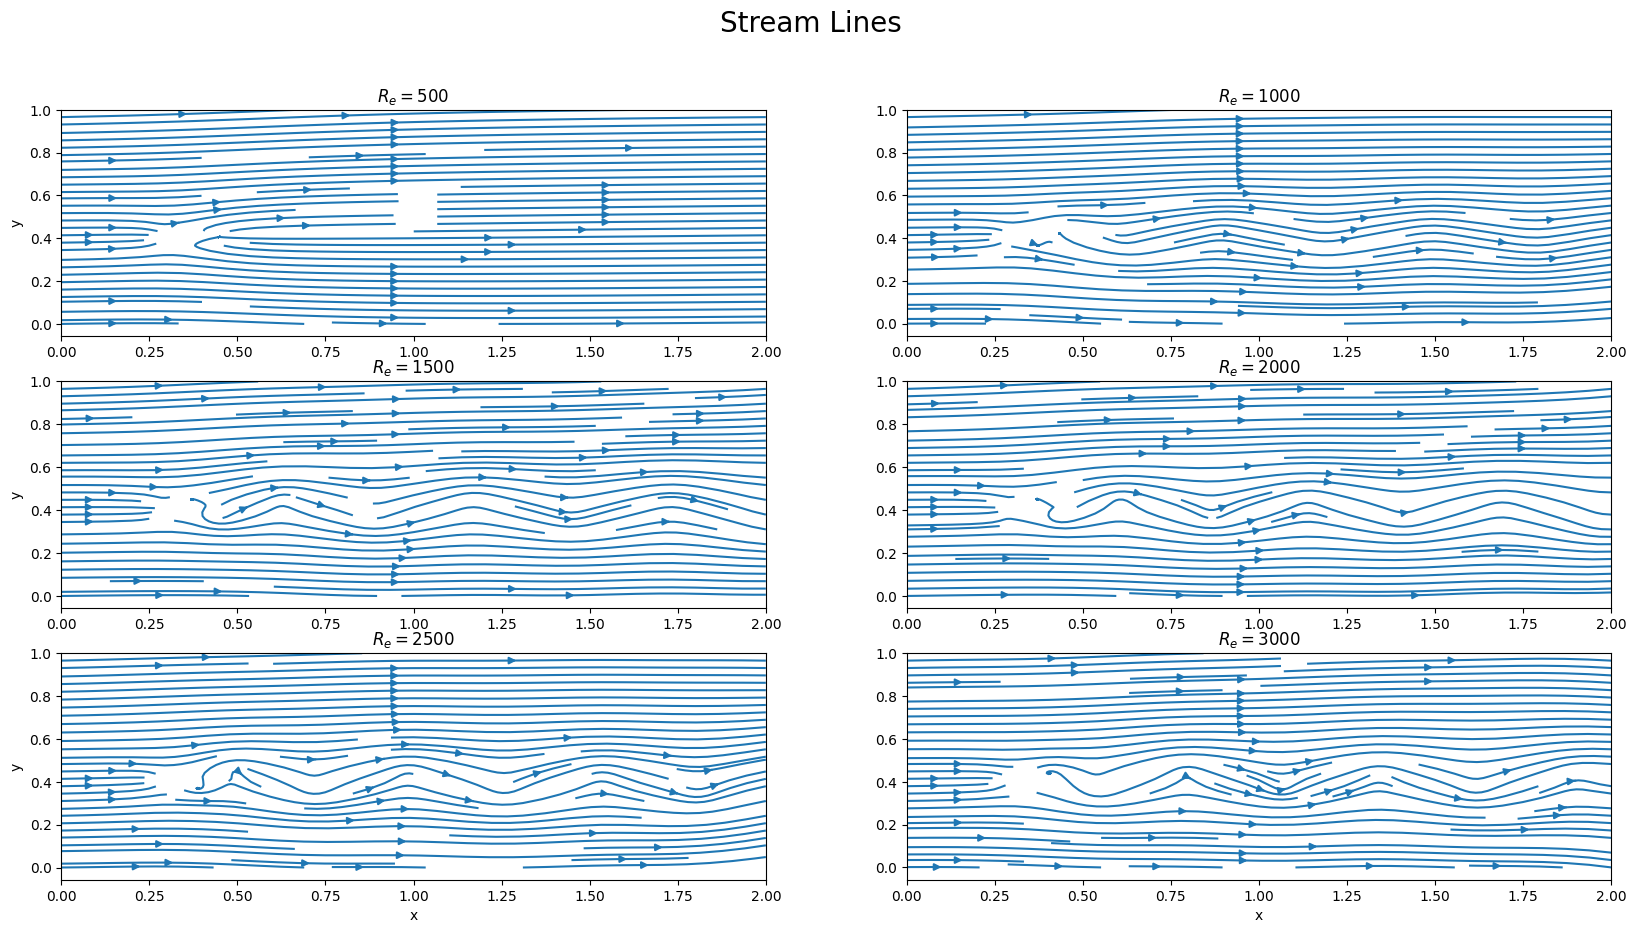

In [ ]:
fig, ax = plt.subplots(3,2, figsize = (20,10))
plt.subplots_adjust(hspace = .2)
fig.suptitle("Stream Lines", fontsize = 20)
for i in range(6):
  ax_i = ax[i//2,i%2]
  ux = Ux[i]
  uy = Uy[i]
  ax_i.streamplot(x,y,ux,uy)
  ax_i.set_title(f"$R_e = $" + str(Re[i]))
  ax_i.tick_params(axis = 'x', labelsize = 10)
  ax_i.tick_params(axis = 'y', labelsize = 10)
ax[2,0].set_xlabel("x")
ax[2,1].set_xlabel("x")

ax[0,0].set_ylabel("y")
ax[1,0].set_ylabel("y")
ax[2,0].set_ylabel("y")

Text(0, 0.5, 'y')

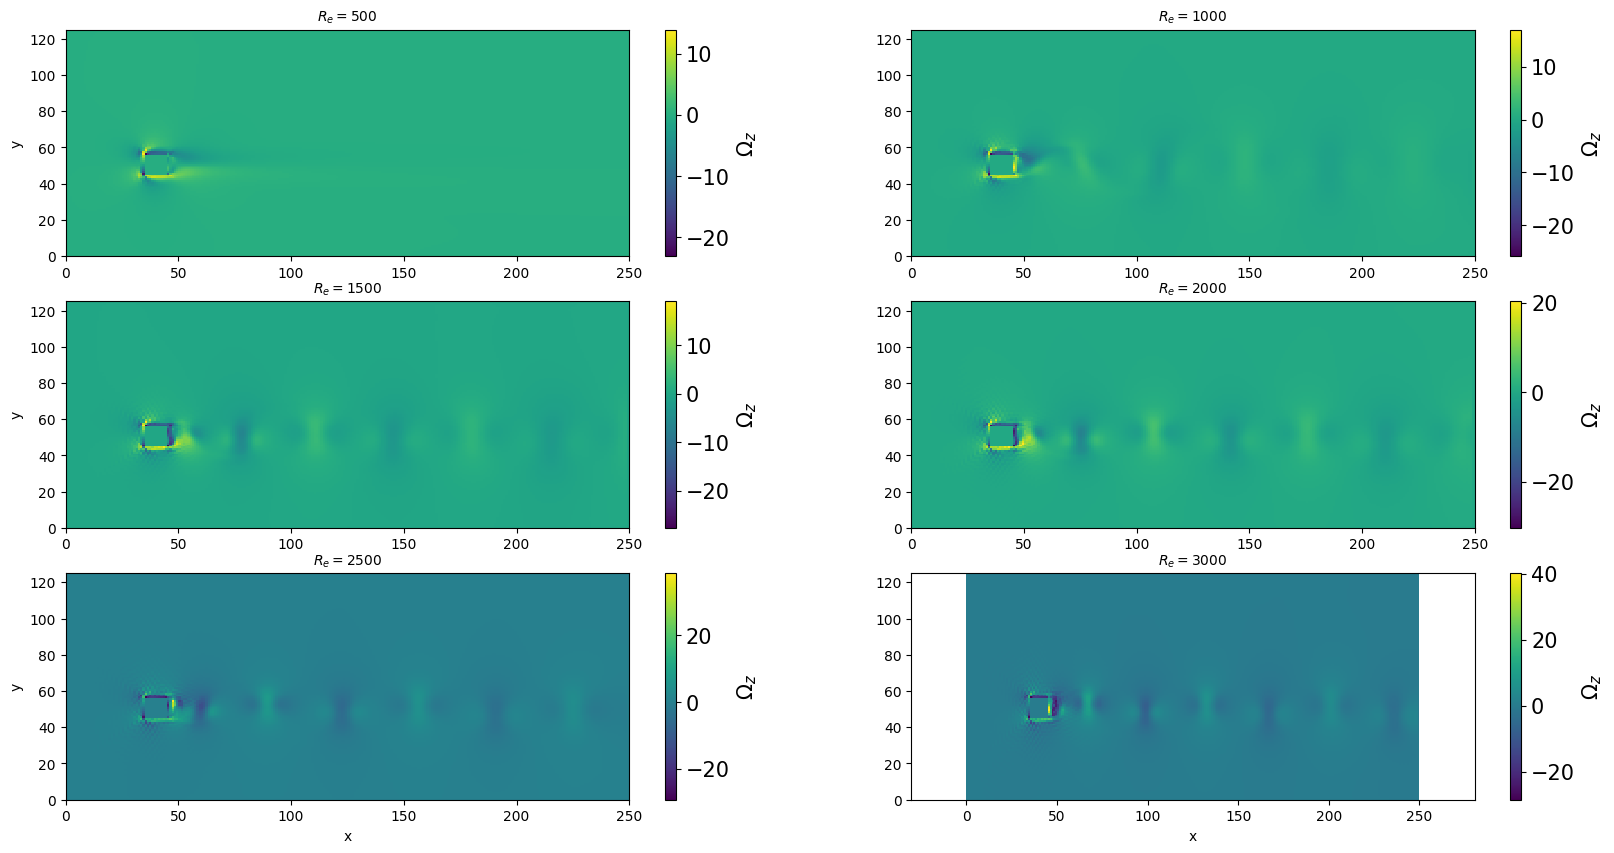

In [ ]:
fig, ax = plt.subplots(3,2,figsize = (20,10))
plt.subplots_adjust(hspace = .2)
for i in range(6):
  ax_i = ax[i//2][i%2]
  map = ax_i.pcolormesh(OmegaZ[i], cmap = 'viridis')
  cb = plt.colorbar(map, ax = ax_i)
  cb.set_label(f'$\Omega_z$', fontsize=15)
  cb.ax.tick_params(labelsize=15)
  ax_i.set_title(f"$R_e =$" + str(Re[i]), fontsize = 10)
  ax_i.tick_params(axis = 'x', labelsize = 10)
  ax_i.tick_params(axis = 'y', labelsize = 10)
  plt.axis('equal')

ax[2,0].set_xlabel("x")
ax[2,1].set_xlabel("x")

ax[0,0].set_ylabel("y")
ax[1,0].set_ylabel("y")
ax[2,0].set_ylabel("y")

In [ ]:
f = 15/(6000*dt)
St = f*2*R*dx/(M0*c0_real)
print(St)

0.14433756729740643


<b style="color:#0055FA">8. Etudier l'évolution de ce résultat avec la résolution (nombre de maille le long du cylindre).

**Commentaires**

___


___

<b style="color:#0055FA">9. Compléter le tableau suivant en faisant varier le Reynolds et la résolution si besoin.

Résultats:

| Re  |$C_d$| $S_t$ |
| --- | --- | --- |
| 20  | 0.9 | 0 |
| 50  | 0.95 | 0 |
| 80  | 0.947 | 0.14433 |
| 100 | 0.950 | 0.16358 |
| 200 | 0.882 | 0.19245 |
| $Ref_{200}$| 1.41 | 0.16 |

**Commentaires**

___


___

# Conclusion

Présenter ici la synthèse de votre TP en décrivant les points importants et les principaux résultats.


In [ ]:
from IPython.core.display import HTML
style=open('notebooks.css', "r").read()
HTML(style)

FileNotFoundError: [Errno 2] No such file or directory: 'notebooks.css'

<a id="top" style="float:right;" href="http://dynfluid.ensam.eu/"><img style="height:120px;" src="http://dynfluid.ensam.eu/uas/DYNFLUID/logoPrincipal/Logo-DynFluid-Web.png"/></a>
<a style="float:left;" href="http://www.cnam.fr//"><img style="height:120px;" src="https://upload.wikimedia.org/wikipedia/commons/4/45/Logo_ENSTA_Paris.jpg"></a>
<center><a href="#top">Retour en haut de la page</a></center>